In [19]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  7 14:23:53 2024

@author: leo_teja
"""

#------------------------------------------------------------------------------------------#
#----------------------------------- Bibliotecas a utilizar -------------------------#
#------------------------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix           #Importación del modulo scipy que convierte una matriz en una lista
from scipy.sparse import csr_matrix           #Importación del modulo csr_matrix para emplear el método CSR para la solución del sistema de ecuaciones
from scipy.sparse.linalg import spsolve  

from time import time                         #Importación del modulo time para determinar los tiempos de cálculo


def solucion_completa(dt, tsel):
    #------------------------------------------------------------------------------------------#
    #------------- Datos de entrada: Fuente hoja de cálculo excel WMA -------------------------#
    #------------------------------------------------------------------------------------------#
    
    long_x = 15.0                         #Longitud en "x" en [ft]
    teta = 1.0                            #Adimensional [Adim.]
    DH = 1.0                              #coefciente de difusión??? [m2/dia]
    r = -0.02                             #recarga o descarga  [1/dia]
    cr = 0.0                              #concentración de recarga [Adim.]
    nds_x = 30                            #Cantidad de nodos en "x"
    t_sim = 50.8                          #Tiempo de simulación (dias)
    #dt = 0.4                              #Paso de tiempo (dias)
##    dt = 0.1                              #Paso de tiempo (dias)
    # dt = 0.01                              #Paso de tiempo (dias)
    q_inf = 1.0                           #Condición de frontera izquierda en [m/dia]
    c_inf = 0.0                           #Condición de frontera izquierda en [m/dia]
    c_out = 0.0                           #Condición de frontera derecha en [m/dia]
    long_ini_cini = 1.0                   #Posición inicial de las condiciones iniciales de concentraciones en [ft]
    long_fin_cini = 7.5                   #Posición final de las condiciones iniciales de concentraciones en [ft]
    
    #------------------------------------------------------------------------------------------#
    #--------------------------- Malla de simulación espcio y tiempo ----------------------------#
    #------------------------------------------------------------------------------------------#
    
    delta_x = long_x/nds_x                                           #Delta en "x" considerando un espaciamiento homogéneo entre nodos en [m]
    xi = np.linspace((delta_x)/(2), long_x-(delta_x/2), nds_x)        #Posición de los nodos en "i" en [m]
    x_frntrs = np.linspace(0, long_x, nds_x+1)                      #Posición de las fronteras "i+1/2 e i-1/2" en [m]
    
    t = np.arange(0, t_sim+0.01, dt)           #Vector de tiempo en [Días]
    nt = len(t)-1                             #numero de pasos de tiempo 
    
    #------------------------------------------------------------------------------------------#
    #---------- Calculando los valores de q para cada nodo y fronteras de la celdas ----------------#
    #------------------------------------------------------------------------------------------#
    
    q_frnts = np.zeros(nds_x+1)                       #Vector de q en las fronteras de las celdas en [m/dias]
    q_i = np.zeros(nds_x)                             #Vector de q en los nodos o centros "i" en [m/dias]
    for i in range(0, nds_x+1):
        if i == 0:
            q_frnts[i] = q_inf                        #Valor de q en 0-1/2 de la primera frontera (que sería la condición de frontera izquierda de qinf)
        else:
            q_frnts[i] = q_frnts[i-1]+(r*delta_x)    #Valor de q en las demás fronteras en i-1/2, i+1/2 
            q_i[i-1] = (q_frnts[i-1]+q_frnts[i])/2   #Valor de q en los nodos i
    
    
    #------------------------------------------------------------------------------------------#
    #------ Definiendo vectores y matriz  para el sistema de eq lineales ---------------------#
    #------------------------------------------------------------------------------------------#
    
    Beta_W = np.zeros(nds_x); Beta_C = np.zeros(nds_x); Beta_E = np.zeros(nds_x); Beta_r = np.zeros(nds_x)                          
    Lambda_W = np.zeros(nds_x); Lambda_C = np.zeros(nds_x); Lambda_E = np.zeros(nds_x); Lambda_r = np.zeros(nds_x)                          
    c_ini = np.zeros(nds_x)                       #Vector de condiciones iniciales de c
    c_n = np.zeros(nds_x)                         #Vector de valor de c a un paso de tiempo n (necesario para la solución del sistema de ecuaciones)
    c_v = np.zeros(nds_x)                         #Vector de valor de c a un paso de tiempo n+1
    solcns_c = np.zeros((nt+1, nds_x))            #Matriz de guardado de las c para cada paso de tiempo y en toda la malla 1D (incluyendo las condiciones iniciales al tiempo cero)
    
    #------------------------------------------------------------------------------------------#
    #---------------------------- Definiendo condiciones iniciales ----------------------------#
    #------------------------------------------------------------------------------------------#
    
    for i in range(0, nds_x):
        if xi[i] >= long_ini_cini and xi[i] <= long_fin_cini:   #Si los nodos en xi están dentro de este rango se tiene la condición inicial de c = 1
            c_ini[i] = 1
        else:
            c_ini[i] = 0                          #Si los nodos en xi no se encuentran dentro del rango se tiene la condición inicial de c = 0
    
    c_n[:] = c_ini[:]                             #Inicializando el vector c_n
    solcns_c[0][:] = c_n[:]                       #Guardando el valor de las condiciones iniciales en la matriz de soluciones de c
    
    #------------------------------------------------------------------------------------------#
    #------------------------ Inicio del ciclo solución en el tiempo --------------------------#
    #------------------------------------------------------------------------------------------#
    tiempoComputo_inicial = time()       
    
    for ti in range(0, nt):
            
        #--------------------------------------------------------------------------------------#
        #-- Calculando los coeficientes "Beta" y Lambdas se usan las formulas de las diapositivas--------#
        #--------------------------------------------------------------------------------------# 
        
        for i in range(0, nds_x):                                                               
            Beta_W[i] =  q_i[i]/(2*delta_x)+DH/(delta_x**2)                              
            Beta_C[i] = -(2*DH)/(delta_x**2)-r
            Beta_E[i] = -q_i[i]/(2*delta_x)+DH/(delta_x**2)                          
            Beta_r[i] =  r
    
            Lambda_W[i] = (Beta_W[i]*dt)/teta                             
            Lambda_C[i] = 1+(Beta_C[i]*dt)/teta
            Lambda_E[i] = (Beta_E[i]*dt)/teta                          
            Lambda_r[i] = (Beta_r[i]*dt)/teta
            
            #--------------------------------------------------------------------------------------#
            #------------------------------ Solución  ---------------------------------------------#
            #--------------------------------------------------------------------------------------# 
            
            # Hacemos la suma por trozos o bien considerando el nodo central y los dos vecinos
            if i==0:
                # c_v[i]=Lambda_W[i]*(2*c_inf-c_n[i])+(Lambda_C[i]+Lambda_r[i])*c_n[i]+Lambda_E[i]*c_n[i+1]  #c_inf dirichlet
                cte=(DH/delta_x-q_inf/2)/(DH/delta_x+q_inf/2)
                c_v[i]=Lambda_W[i]*(cte*c_n[i])+(Lambda_C[i]+Lambda_r[i])*c_n[i]+Lambda_E[i]*c_n[i+1]  #c_inf robin
    
            if((i>0)and(i<nds_x-1)):
                c_v[i]=Lambda_W[i]*c_n[i-1]+(Lambda_C[i]+Lambda_r[i])*c_n[i]+Lambda_E[i]*c_n[i+1]  
        
            if i==nds_x-1:
                c_v[i]=Lambda_W[i]*c_n[i-1]+(Lambda_C[i]+Lambda_r[i])*c_n[i]+Lambda_E[i]*c_n[i] #celda dummy c_i+1=c_i 
            
    
        solcns_c[ti+1][:] = c_v[:]  
        c_n[:] = c_v[:]                                                                         #Guardando el valor de c al tiempo n que se utilizará en el siguiente paso de tiempo

        my_time = round(dt*(ti+1),2) 
        if my_time % 10 == 0:
            print("tiempo de simulacion: " +str(my_time)+" dias" )
    
    
    #------------------------------------------------------------------------------------------#
    #---------------------- Tiempo de ejecución del modelo de simulación ----------------------#
    #------------------------------------------------------------------------------------------# 
    
    tiempoComputo_final=time()                                                                         #Toma el valor de tiempo final de ejecución, para  calcuar el tiempo total de la simulación
    tiempo_ejec_seg=(tiempoComputo_final-tiempoComputo_inicial)                                               #Calcula el tiempo total de simulación, pasado a segundos
    tiempo_ejec_min=(tiempoComputo_final-tiempoComputo_inicial)/60                                            #Calcula el tiempo total de simulación, pasado a minutos
    print("\nTiempo de Ejecución:",tiempo_ejec_seg, "[Segundos]","\t", tiempo_ejec_min, "[Minutos]\n")
    print("|------------------------------------------------------------------------------|")
    print("|-------------------------- FIN DE LA SIMULACIÓN xdxd -------------------------|")
    print("|------------------------------------------------------------------------------|")
    
    
    #------------------------------------------------------------------------------------------#
    #--------------------------- Graficando todos los resultados ------------------------------#
    #------------------------------------------------------------------------------------------#
    
    plt.figure('Graf_cs',figsize=(9,8))
    plt.style.use('fast')
    plt.minorticks_on()
    plt.title('Perfil de c vs distancia en el tiempo')
    for i in range(0, nt+1):
        plt.plot(xi, solcns_c[i][:]) 
    # plt.legend(loc=4)
    plt.xlabel("Distancia x [$m$]")
    plt.ylabel("Concentraciones [$adim$]")                                                                        
    plt.grid(True,which='major', color='w', linestyle='-')
    plt.grid(True, which='minor', color='w', linestyle='--')
    
    
    #--------------------------------------------------------------------------------------------------#
    #------------------------ Graficando un solo resultado y comparandolo vs WMAI ----------------------#
    #---------------------------------------------------------------------------------......---------#
    
    
    WMA_I=pd.read_excel('comparativa.xlsx', sheet_name='WMA_I')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
    #WMA_I
    data_set = WMA_I.iloc[13:,9:39].to_numpy()
    #data_set
    
    plt.figure('Graf2_1r', figsize=(12,8))
    plt.title('Comparativa explícito vs condicion inicial')
##    tsel=10    #tiempo seleccionado de hoja excel
    multiplo=int(0.4/dt)
    if multiplo==1:
        tselExp=tsel
    else:
        tselExp=multiplo*tsel
    
    lgImp=str(round(tsel*0.4,2))
    lgExp=str(round(tselExp*dt,2))
    plt.plot(xi, solcns_c[0][:], "-r"  , label="Condicion inicial")
    plt.plot(xi, solcns_c[tselExp][:], "-r*", label="Tiempo de simulacion "+lgExp+" dias este nootebook")
    plt.plot(xi, data_set[tsel][:], "-.*m", label="Tiempo de simulacion "+lgImp+" dias WMA_I" )
    plt.xlabel("Distancia x [$m$]"), plt.ylabel("c $[adim]$")
    plt.legend(loc=0); plt.minorticks_on()
    plt.grid(True,which='major', color='w', linestyle='-')
    plt.grid(True, which='minor', color='g', linestyle='--')
    plt.show()

tiempo de simulacion: 10.0 dias
tiempo de simulacion: 20.0 dias
tiempo de simulacion: 30.0 dias
tiempo de simulacion: 40.0 dias
tiempo de simulacion: 50.0 dias

Tiempo de Ejecución: 0.11651730537414551 [Segundos] 	 0.0019419550895690917 [Minutos]

|------------------------------------------------------------------------------|
|-------------------------- FIN DE LA SIMULACIÓN xdxd -------------------------|
|------------------------------------------------------------------------------|


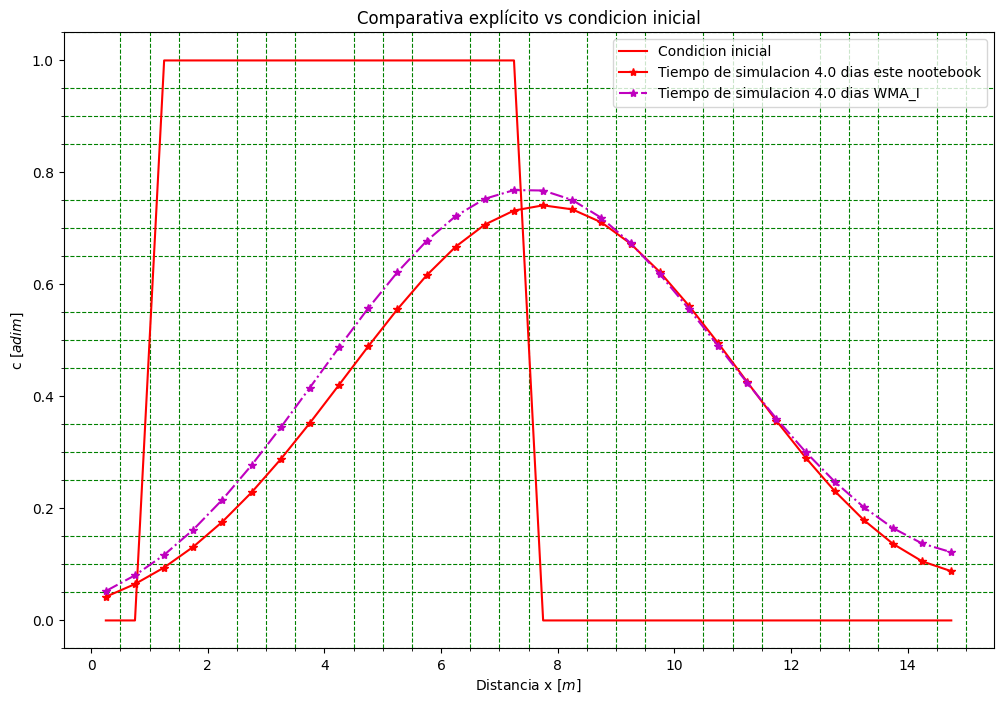

In [22]:
solucion_completa(0.1, 10)

In [23]:
tmax = solcns_c.shape[0]
def comparacion(tsel):
    WMA_I=pd.read_excel('comparativa.xlsx', sheet_name='WMA_I')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
    #WMA_I
    data_set = WMA_I.iloc[13:,9:39].to_numpy()
    #data_set
    
    plt.figure('Graf2_1r', figsize=(12,8))
    plt.title('Comparativa explícito vs condicion inicial')
##    tsel=10    #tiempo seleccionado de hoja excel
    multiplo=int(0.4/dt)
    if multiplo==1:
        tselExp=tsel
    else:
        tselExp=multiplo*tsel
    
    lgImp=str(round(tsel*0.4,2))
    lgExp=str(round(tselExp*dt,2))
    plt.plot(xi, solcns_c[0][:], "-r"  , label="Condicion inicial")
    plt.plot(xi, solcns_c[tselExp][:], "-r*", label="Tiempo de simulacion "+lgExp+" dias este nootebook")
    plt.plot(xi, data_set[tsel][:], "-.*m", label="Tiempo de simulacion "+lgImp+" dias WMA_I" )
    plt.xlabel("Distancia x [$m$]"), plt.ylabel("c $[adim]$")
    plt.legend(loc=0); plt.minorticks_on()
    plt.grid(True,which='major', color='w', linestyle='-')
    plt.grid(True, which='minor', color='g', linestyle='--')
    plt.show()

In [25]:
import ipywidgets as widgets
tmax = solcns_c.shape[0]
print(tmax)
widgets.interactive(comparacion,
                    tsel = widgets.IntSlider(min=0, max = tmax, value=0, step=1))

509


interactive(children=(IntSlider(value=0, description='tsel', max=509), Output()), _dom_classes=('widget-intera…